<a href="https://colab.research.google.com/github/sharmadeep441/Dementia-detection-system/blob/main/Updated_CNN_Minor_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K


from typeguard import typechecked
from typing import Optional

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd ~/dataaa


fileId = '1k9objkB5kqv30TgS1HHYybHmA2rPm_M0'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

os.makedirs('datasets')
os.chdir('datasets')

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

[Errno 2] No such file or directory: '/root/dataaa'
/content
Extracted zip file 1k9objkB5kqv30TgS1HHYybHmA2rPm_M0.zip


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:

train_dataset  = train_datagen.flow_from_directory(directory = '/content/datasets/Alzheimer_s Dataset/train',
                                                   target_size = (180,180),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                        
                                                   batch_size = 32)

Found 4098 images belonging to 4 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/datasets/Alzheimer_s Dataset/train',
                                                  target_size = (180,180),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/datasets/Alzheimer_s Dataset/test',
                                                  target_size = (180,180),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1279 images belonging to 4 classes.


In [ ]:
from keras.layers import AveragePooling2D

def build_model():
    
    '''Sequential Model creation'''
    model = Sequential()
    model.add(Conv2D(32,(3,3),padding='same',strides=(2, 2),input_shape = (180,180,3),activation='relu'))
    
    model.add(Conv2D(32,(3,3),padding='same',strides=(2, 2),activation='relu'))
    
    
    model.add(Conv2D(64,(3,3),padding='same',strides=(2, 2),activation='relu'))
    
    
    model.add(Conv2D(64,(3,3),padding='same',strides=(2, 2),activation='relu'))
    
    model.add(Conv2D(64,(3,3),padding='same',strides=(2, 2),activation='relu'))
    
    model.add(Conv2D(64,(3,3),padding='same',strides=(2, 2),activation='relu'))
    
    
    model.add(Conv2D(64,(3,3),padding='same',strides=(2, 2),activation='relu'))
    model.add(AveragePooling2D(pool_size=(2,2),strides=1,padding = 'same'))
    
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 90, 90, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 64)          36928     
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 conv2d_6 (Conv2D)           (None, 2, 2, 64)          3

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = METRICS)

In [ ]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 30,
                        verbose = 1)
                  

Epoch 1/30
129/129 [==============================] - 68s 508ms/step - loss: 1.0646 - accuracy: 0.7534 - precision: 0.5142 - recall: 0.2426 - auc: 0.7784 - f1_score: 0.2702 - val_loss: 1.0272 - val_accuracy: 0.7774 - val_precision: 0.5763 - val_recall: 0.4135 - val_auc: 0.8190 - val_f1_score: 0.4799
Epoch 2/30
129/129 [==============================] - 65s 506ms/step - loss: 1.0481 - accuracy: 0.7589 - precision: 0.5417 - recall: 0.2316 - auc: 0.7833 - f1_score: 0.2600 - val_loss: 1.0352 - val_accuracy: 0.7505 - val_precision: 0.5010 - val_recall: 0.5005 - val_auc: 0.8192 - val_f1_score: 0.5006
Epoch 3/30
129/129 [==============================] - 65s 505ms/step - loss: 1.0370 - accuracy: 0.7617 - precision: 0.5542 - recall: 0.2384 - auc: 0.7875 - f1_score: 0.2863 - val_loss: 1.0576 - val_accuracy: 0.7502 - val_precision: 0.5005 - val_recall: 0.5005 - val_auc: 0.7720 - val_f1_score: 0.5005
Epoch 4/30
129/129 [==============================] - 66s 507ms/step - loss: 1.0375 - accuracy: 0

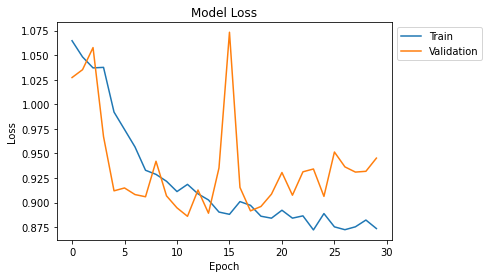

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

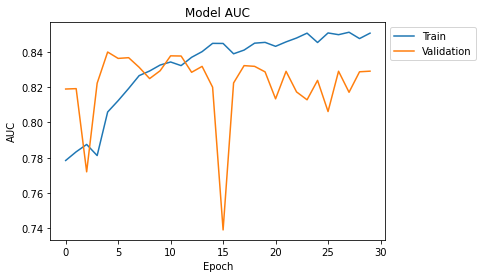

In [ ]:
# Summarize history for loss

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
scores = model.evaluate_generator(test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.7939796447753906
Precision =  0.6459143757820129
Recall =  0.38936668634414673
AUC =  0.8340491652488708
F1_score =  0.4850277304649353


In [ ]:
# save the model to disk
import pickle
pickle.dump(model, open('cnn_model.p', 'wb'))

INFO:tensorflow:Assets written to: ram://e9fa70d6-a1cd-4daa-b60e-2e2abed98750/assets


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
----------------------
                   precision    recall  f1-score   support

    MildDemented       0.14      0.01      0.01       143
ModerateDemented       0.00      0.00      0.00        10
     NonDemented       0.49      0.48      0.49       512
VeryMildDemented       0.35      0.49      0.41       358

        accuracy                           0.42      1023
       macro avg       0.24      0.25      0.23      1023
    weighted avg       0.39      0.42      0.39      1023



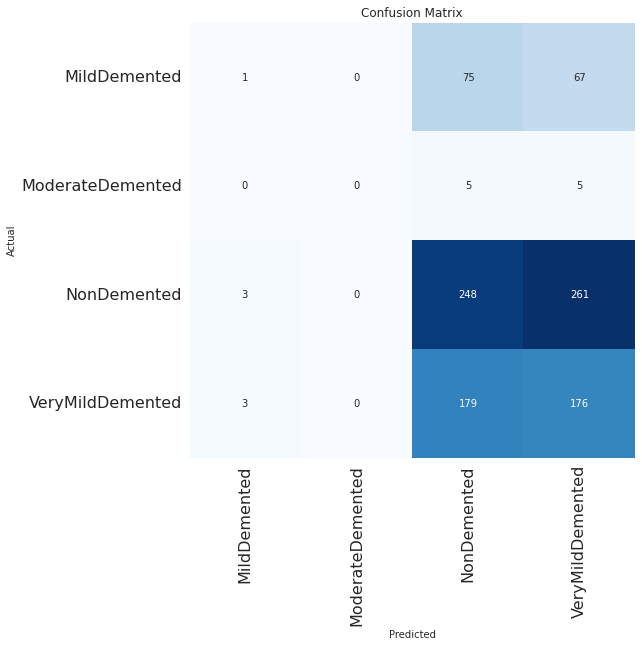

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
def cm_cr(test_gen, model):
    preds=model.predict(test_gen)    
    labels=test_gen.labels
    classes=list(test_gen.class_indices.keys()) # ordered lst of class names 
    pred_list=[ ] # will store the predicted classes here
    true_list=[]
    for i, p in enumerate (preds):
        index=np.argmax(p)
        pred_list.append(classes[index])
        true_list.append(classes[labels[i]])
    y_pred=np.array(pred_list)
    y_true=np.array(true_list)
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)
    cm = confusion_matrix(y_true, y_pred )        
    length=len(classes)
    if length<8:
        fig_width=8
        fig_height=8
    else:
        fig_width= int(length * .5)
        fig_height= int(length * .5)
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(length)+.5, classes, rotation= 90, fontsize=16)
    plt.yticks(np.arange(length)+.5, classes, rotation=0, fontsize=16)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

cm_cr(valid_dataset, model)